# Target Encoding

TODO: intro about ways to encode categorical cols: label, one-hot, and entity embbeddings (if you were using a neural net or gradient descent-based method, but can't do that if you want to use say xgboost).  Problem w/ label encoding is doesn't work at all w/ non-ordinal features w/ a high # of categories (or at all at all w/ a linear model).  Problem w/ one-hot is that it can create a crazy number of columns.  

TODO: One solution is to use target encoding, where you replace each category with the mean target value for samples having that category.  However, blindly using target encoding can allow data leakage, leading to very poor cross-validated or validation performance!  To fix that problem, have to do cross-fold target encoding.

TODO: but even with cross-fold target encoding, there are situations where you'd be better off with one-hot or other encoding methods: one-hot is usually better in situations with few categories, and one-hot is definitely better when there are important interaction effects.

In this post we'll evaluate different encoding schemes, build a cross-fold target encoder to mitigate the drawbacks of the naive target encoder, and determine how the performance of predictive models change based on the type of category encoding used, the number of categories in the dataset, and the presence of interaction effects. 

TODO: outline

First let's import the packages we'll be using.

In [0]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

## Data

To evaluate the effectiveness of different encoding algorithms, we'll want to be able to generate data with different numbers of samples, features, and categories.  Let's make a function to generate categorical datasets, which allows us to set these different aspects of the data.

In [0]:
def make_categorical_regression(n_samples=100,
                                n_features=10,
                                n_informative=10,
                                n_categories=10,
                                noise=1.0):
    """Generate a regression problem with only categorical features.
  
    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    n_features : int
        Number of categorical features to generate
    n_informative : int
        Number of features which carry information about the target
    n_categories : int or list or ndarray
        Number of categories per feature.
    noise : float
        Noise to add to target

    Returns
    -------
    X : pandas DataFrame of shape (n_samples, n_features)
        Categorical features.
    y : pandas Series of shape (n_samples,)
        Target variable.
    """

    # Check inputs
    if not isinstance(n_samples, int):
        raise TypeError('n_samples must be an int')
    if n_samples < 2:
        raise ValueError('n_samples must be one or greater')
    if not isinstance(n_features, int):
        raise TypeError('n_features must be an int')
    if n_features < 2:
        raise ValueError('n_features must be one or greater')
    if not isinstance(n_informative, int):
        raise TypeError('n_informative must be an int')
    if n_informative < 2:
        raise ValueError('n_informative must be one or greater')
    if not isinstance(n_categories, int):
        raise TypeError('n_categories must be an int')
    if n_categories < 2:
        raise ValueError('n_categories must be one or greater')
    if not isinstance(noise, float):
        raise TypeError('noise must be a float')
    if noise < 0:
        raise ValueError('noise must be positive')
        
    # Generate random categorical data
    categories = np.random.randint(n_categories,
                                   size=(n_samples, n_features))
    
    # Generate random values for each category
    cat_vals = np.random.randn(n_categories, n_features)
    
    # Set non-informative columns' effect to 0
    cat_vals[:,:(n_features-n_informative)] = 0
    
    # Compute target variable from those categories and their values
    y = np.zeros(n_samples)
    for iC in range(n_features):
      y += cat_vals[categories[:,iC], iC]
    
    # Add noise
    y += noise*np.random.rand(n_samples)
    
    # Generate dataframe from categories
    cat_strs = [''.join([chr(ord(c)+49) for c in str(n)]) 
                for n in range(n_categories)]
    X = pd.DataFrame()
    for iC in range(n_features):
        col_str = 'feature_'+str(iC)
        X[col_str] = [cat_strs[i] for i in categories[:,iC]]
            
    # Generate series from target
    y = pd.Series(data=y, index=X.index)
    
    # Return features and target
    return X, y

Now, we can easily generate data to test our encoders on:

In [0]:
# Generate categorical data and target
N = 10000
X, y = make_categorical_regression(n_samples=N,
                                   n_features=10,
                                   n_categories=5)

# Split into test and training data
N2 = int(N/2)
X_train = X.iloc[:N2, :]
y_train = y[:N2]
X_test = X.iloc[N2:, :]
y_test = y[N2:]

The features are all categorical (stored as "objects"):

In [0]:
X_train.sample(10)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
4998,b,a,d,e,e,c,d,b,c,c
2859,d,d,c,c,d,d,a,c,b,c
4824,a,e,c,d,e,b,b,d,d,d
662,c,d,b,d,a,d,a,b,e,e
1093,e,c,a,a,c,d,d,a,d,d
1911,d,a,b,b,e,c,c,d,e,e
2275,e,b,a,e,c,e,d,b,a,d
3436,a,c,d,d,b,d,e,a,b,a
1969,a,a,e,b,d,a,b,c,d,b
1880,d,d,d,c,c,a,d,b,d,d


In [0]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
feature_0    5000 non-null object
feature_1    5000 non-null object
feature_2    5000 non-null object
feature_3    5000 non-null object
feature_4    5000 non-null object
feature_5    5000 non-null object
feature_6    5000 non-null object
feature_7    5000 non-null object
feature_8    5000 non-null object
feature_9    5000 non-null object
dtypes: object(10)
memory usage: 390.7+ KB


But the target variable is continuous:

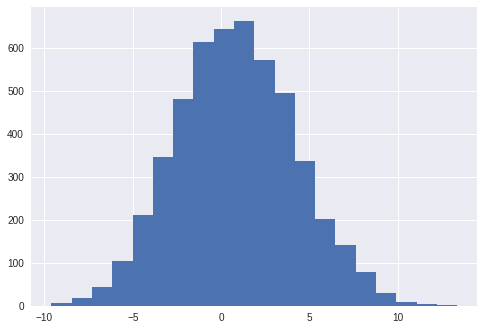

In [0]:
y_train.hist(bins=20)

Let's see which category encoding scheme best allows us to predict the target variable!

## Baseline

For comparison, how well would we do if we just predicted the mean?  We'll use the mean absolute error as our performance metric.

In [0]:
mean_absolute_error(y_train, 
                    np.full(y_train.shape[0], y_train.mean()))

2.4228639649417563

So, we should definitely be shooting for a mean absolute error of less than 1.64!

## Label Encoding

TODO: prediction w/ simple label encoding, which is just replacing each unique category w/ a unique integer

TODO: note that we could also use Scikit-learn's LabelEncoder

In [0]:
def label_encode(df, cols=None, inplace=False):
    """Convert categorical columns to unique integers.

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame in which to convert columns
    cols : list of str
        List of columns to encode.
        Default is to encode all the categorical columns in df.
    inplace : bool
        Whether to modify df as-is (True) or create a copy (False).
        Default = False
        
    Returns
    -------
    dict
        Mapping between categories and their integer labels.
    """
    
    # Modify in-place?
    if not inplace:
        df = df.copy()

    # Do for all "object" columns if not specified
    if cols is None:
        cols = [col for col in df if str(df[col].dtype)=='object']
    if len(cols) == 0:
        return

    # Make list if not
    if isinstance(cols, str):
        cols = [cols]

    # Map each column
    maps = dict()
    for col in cols:

        # Create the map from objects to integers
        maps[col] = dict(zip(
            df[col].values, 
            df[col].astype('category').cat.codes.values
        ))

        # Determine appropriate datatype
        max_val = max(maps[col].values())
        if df[col].isnull().any(): #nulls, so have to use float!
            if max_val < 8388608:
                dtype = 'float32'
            else:
                dtype = 'float64'
        else:
            if max_val < 256:
                dtype = 'uint8'
            elif max_val < 65536:
                dtype = 'uint16'
            elif max_val < 4294967296:
                dtype = 'uint32'
            else:
                dtype = 'uint64'

        # Map the column
        df[col] = df[col].map(maps[col]).astype(dtype)

    # Return the maps used
    return df

In [0]:
# Label-encode the categorical data
X_label_encoded = label_encode(X_train)

Now we've converted the categories to integers:

In [0]:
X_label_encoded.sample(10)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
3463,0,1,1,4,0,4,3,3,0,4
3545,3,1,4,0,0,3,2,0,4,0
2342,4,3,0,2,3,1,0,3,4,2
4887,0,1,2,4,4,2,0,3,0,1
935,3,2,2,1,1,4,1,3,3,0
2019,2,2,1,4,4,4,3,2,0,1
2776,1,0,4,3,4,2,3,4,3,1
2371,2,3,2,1,0,4,2,4,4,4
4930,2,3,2,2,4,2,0,0,3,0
4662,3,0,3,1,2,3,2,2,4,0


But again, these integers aren't related to the categories in any meaningful way - aside from the fact that each unique integer corresponds to a unique category.

TODO: then we can make a model to predict

In [0]:
# Regression model
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
    #('regressor', XGBRegressor())
])

# Cross-validated MSE
mae_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(model, X_label_encoded, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 2.0256164635158656 +/- 0.0302061333016236


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y

TODO: That's not much better than just predicting the mean!

However, the error is no worse on the test data than the cross-validated error on the training data.



In [0]:
# MSE on test data
X_test_le = label_encode(X_test)
model.fit(X_label_encoded, y_train)
y_pred = model.predict(X_test_le)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Validation MAE: 2.4583749152396615


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


## One-hot Encoding

TODO: one-hot encoding, sometimes aka "Dummy encoding"

(note that we could also use Scikit-learn's OneHotEncoder)

In [0]:
def one_hot_encode(df, cols=None, reduce_df=False, inplace=False):
    """One-hot encode columns.

    Parameters
    ----------
    df : pandas DataFrame
        Dataframe from which to one-hot encode columns
    cols : list of str
        Columns in df to one-hot encode
        Default is to encode all the categorical columns in df.
    reduce_df : bool
        Whether to add N-1 one-hot columns for a column with N categories. 
        E.g. for a column with categories A, B, and C:
        When reduce_df is True, A=[1, 0], B=[0, 1], and C=[0, 0]
        When reduce_df is False, A=[1, 0, 0], B=[0, 1, 0], and C=[0, 0, 1]
        Default = False
    inplace : bool
        Whether to modify df as-is (True) or create a copy (False).
        Default = False
        
    Returns
    -------
        Nothing, modifies df in-place.
    """
    
    # Modify in-place?
    if not inplace:
        df = df.copy()

    # Do for all "object" columns if not specified
    if cols is None:
        cols = [col for col in df if str(df[col].dtype)=='object']

    # Make list if not
    if isinstance(cols, str):
        cols = [cols]

    # Check columns are in df
    for col in cols:
        if col not in df:
            raise ValueError('Column \''+col+'\' not in DataFrame')

    # One-hot encode each column
    for col in cols:
        uniques = df[col].unique()
        if len(uniques) < 2:
            print('Warning: column '+col+' has <2 unique values, removing it')
        elif len(uniques) == 2: #only 2 unique categories, just add binary col
            new_col = col+'_'+str(uniques[0])
            df[new_col] = (df[col] == uniques[0]).astype('uint8')
        else:
            for u_val in uniques:
                new_col = col+'_'+str(u_val)
                df[new_col] = (df[col] == u_val).astype('uint8')
            if reduce_df:
                del df[new_col]

    # Delete original columns from dataframe
    for col in cols:
        del df[col]
        
    # Return the dataframe
    return df

In [0]:
# One-hot-encode the categorical data
X_one_hot = one_hot_encode(X_train)

Now, instead of replacing categories with integer labels, we've created a new column for each category in each original column.  The value in a given column is 1 when the original category matches, otherwise the value is 0.

In [0]:
X_one_hot.sample(10)

,feature_0_e,feature_0_b,feature_0_d,feature_0_a,feature_0_c,feature_1_e,feature_1_d,feature_1_a,feature_1_b,feature_1_c,...,feature_8_d,feature_8_b,feature_8_a,feature_8_e,feature_8_c,feature_9_c,feature_9_a,feature_9_b,feature_9_e,feature_9_d
2765,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4526,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4708,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
238,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2703,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1292,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2239,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3900,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4215,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1068,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


We can fit the same model with the one-hot encoded data as we fit to the label-encoded data.

In [0]:
# Regression model
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
    #('regressor', XGBRegressor())
])

# Cross-validated MSE
scores = cross_val_score(model, X_one_hot, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 0.2503776209699835 +/- 0.0043136488351542355


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y

TODO: much better!

TODO: compare CV performance to validation performance

## Target Encoding

TODO: target encoding replaces categorical vals w/ the mean of the target for that category

In [0]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target-encode all 
            categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

TODO: cross-validated performance is great! :D

TODO: but performance on test data goes way down as compared to cross-val performance!

## Cross-Fold Target Encoding

TODO: problems w/ just target encoding (your performance on the test data goes way down relative to your CV score), and why it happens (b/c you're causing data leakage by allowing i-th sample's y variable to effect the value of the i-th sample's X variable which you're encoding) 

TODO: this can be fixed w/ cross-fold target encoding

In [0]:
class TargetEncoderCV(TargetEncoder):
    """Cross-validated target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-validated target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-validation splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-validated target encoding for the training fold, and uses
        normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:], y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

TODO: cross-val performance (compare to cross-val performance of one-hot, and cross-val performance of naive target encoder)

TODO: performance on validation data (compare to val performance of one-hot and naive target encoder)

## Dependence on Number of Categories

TODO: not using cross-fold TE is worse when there are more categories.

TODO: but if you have a very small number of categories, you may be better off using one-hot (compare mae's as a fn of #categories/#samples)

## Effect of Interactions

TODO: target encoding doesn't capture interactions very well, which one-hot does (in theory?  simulate data w/ important interaction effects and see if it does better than target encoder)

In [0]:
# TODO: add some sort of interactions param to make_categorical_regression func?